# Data Science CapStone Project- Finding the Ideal Location to open a Pizzeria in Colombo Sri Lanka

### The two objectives of this notebook are,

1. Locate clusters of suburbs of the city with venue types that attract spending (on restaurants).
2. In desirable clusters find suburbs that have low presence of casual and fast casual dining restaurants

Import necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import distance


import requests # library to handle requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics 
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA #Principal Component Analysis


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
import matplotlib.cm as cm

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


print('Libraries imported.')

Libraries imported.


In [2]:
def get_lat_lng(address):
    """
    This funtion is used to convert an address string to a latitude and logitude value.
    
    eg:- get_lat_lng('Toronto, Ontario')
    
    returns  43.6534817, -79.3839347
    """
    
    try:
    
        location = geolocator.geocode('{}, Colombo, Sri Lanka'.format(address))
        latitude = location.latitude
        longitude = location.longitude
            
        return latitude, longitude
    
    except:
        return None, None

In [3]:
def get_distance(lat1, lng1,lat2,lng2):
    """
    Used to get the distance between two pairs of coordinates
    """
    
    sub=(lat1,lng1)
    ven=(lat2,lng2)
    
    return distance(sub,ven).km

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    """
    For a given locality, latitude and longitude, venues within a specified radius and limit are returned
    """
    
    venues_list=[]
    LIMIT=100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [5]:
def return_most_common_venues(row, num_top_venues):
    """Used to calculate the most common N venues in a locality
    """
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Get html data from wikipedia

In [6]:
wiki_link='https://en.wikipedia.org/wiki/Category:Suburbs_of_Colombo'
res=requests.get(wiki_link)
if res.status_code==200:
    soup=BeautifulSoup(res.text,'html.parser')
else:
    print("Scrape Failed. Retry!\n")

In [7]:
#list to contain suburbs
suburbs=[]

In [8]:
#append suburbs onto list
for x in soup.find_all("div",class_="mw-category")[0].find_all("li"):
    suburbs.append(x.text)

In [9]:
#First item is not a suburb therefore it is dropped
suburbs=suburbs[1:]

Geo-Code Locations 

In [10]:
#A previously geocoded file of colombo suburbs is used 
colombo=pd.read_csv("Colombo.csv")

colombo=colombo[colombo.Suburb.isin(suburbs)]

Map Areas

In [11]:
#Define Colombo Latitude Longitude
latitude=6.927079
longitude=79.861244

In [12]:
# create map of Colombo using latitude and longitude values
map_colombo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(colombo['Latitude'], colombo['Longitude'], colombo['Suburb']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_colombo)  
    
map_colombo

### Use FourSquare to obtain venue details

Four Square credentials

In [13]:
CLIENT_ID = 'D401AJGJPVCSSPFFCVAOAN2ZE2RRTF2OGQDP5OOTHJEXK5NR' # your Foursquare ID
CLIENT_SECRET = 'ETW1QCU54RFBEILWBMCJ11PVGNLUWZMCUWQ5AVGVEHC220VV' # your Foursquare Secret
VERSION = '20200304'

Get venue details

In [30]:
colombo_venues=pd.read_csv("colombo_venues.csv")

In [19]:
colombo_venues = getNearbyVenues(names=colombo['Suburb'],
                                   latitudes=colombo['Latitude'],
                                   longitudes=colombo['Longitude']
                              )

Athurugiriya
Bambalapitiya
Battaramulla
Batuwatta
Bloemendhal
Boralesgamuwa
Borella
Cinnamon Gardens
Colombo
Dalugama
Dehiwala
Dehiwala-Mount Lavinia
Dematagoda
Fort (Colombo)
Grandpass
Havelock Town
Hokandara
Hulftsdorp
Ja-Ela
Kadawatha
Kaduwela, Western Province
Kahathuduwa
Kalubowila
Kandana
Kelaniya
Kiribathgoda
Kirulapana
Kohuwala
Kollupitiya
Kolonnawa
Koswatte
Kotahena
Kotikawatta
Kottawa
Madampitiya
Maha Nuge Gardens
Maharagama
Malabe
Maradana
Mattakkuliya
Modara
Moratuwa
Mount-Lavinia
Narahenpita
Nawala
Nugegoda
Pamankada
Panchikawatte
Pannipitiya
Pelawatte
Peliyagoda
Pettah, Sri Lanka
Piliyandala
Ragama
Rajagiriya
Ratmalana
Slave Island
Sri Jayawardenepura Kotte
Template:Suburbs of Colombo
Thalawathugoda
Union Place
Wattala
Welikada
Wellawatte
Wickramasinhapura


In [20]:
colombo_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Athurugiriya,6.872318,80.000388,Old Athurugiriya Junction,6.868566,80.001166,Bus Stop
1,Athurugiriya,6.872318,80.000388,Araliya Hotel,6.868456,80.001416,Food Stand
2,Athurugiriya,6.872318,80.000388,Walgama Junction,6.869385,79.994476,Intersection
3,Bambalapitiya,6.904361,79.854040,99X Technology,6.905620,79.854946,IT Services
4,Bambalapitiya,6.904361,79.854040,The Cake Factory,6.905188,79.856409,Dessert Shop


In [21]:
colombo_venues.shape

(1827, 7)

Drop duplicated venues that fall into multiple suburbs

In [31]:
colombo_venues['distance']=[get_distance(a,b,c,d) for a, b, c,d in zip(colombo_venues['Neighborhood Latitude'],colombo_venues['Neighborhood Longitude'],
                                           colombo_venues['Venue Latitude'],colombo_venues['Neighborhood Longitude'])] 
 

In [32]:
#sort values by venue and distance
colombo_venues.sort_values(by=['Venue','Venue Latitude','Venue Longitude','distance'],inplace=True)

#drop duplicated values keeping first to ensure shortest distance
colombo_venues.drop_duplicates(subset=['Venue','Venue Latitude','Venue Longitude'],keep='first',inplace=True)

In [33]:
#Save Colombo venues for later use
colombo_venues.to_csv("colombo_venues.csv",index=False,encoding='utf-8')

In [34]:
colombo_venues.shape

(1160, 8)

### Analyze Neighborhoods

In [41]:
#one hot encoding venue categories and adding back neighborhod
colombo_onehot=pd.get_dummies(colombo_venues[['Venue Category']], prefix="", prefix_sep="")
colombo_onehot["Neighborhood"]=colombo_venues.Neighborhood

In [42]:
colombo_onehot.shape

(1160, 190)

### Picking variables that are important to the analysis

In [43]:
variables=['Neighborhood',
 
 'Accessories Store',
 'Airport',
 'Arcade',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 
 'BBQ Joint',
 

 'Bakery',
 'Bar',
 'Beach',
 'Bistro',
 'Boat or Ferry',
 'Boutique',
 'Bowling Alley',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Burger Joint',
 'Cafeteria',
 'Café',
 'Chinese Restaurant',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Comfort Food Restaurant',
 'Concert Hall',
 'Cricket Ground',
 'Cuban Restaurant',
 'Cupcake Shop',
 'Department Store',
 'Design Studio',
 'Dessert Shop',
 'Diner',
 'Donut Shop',
 'Eastern European Restaurant',
 'English Restaurant',
 'Fast Food Restaurant',
 'Fish & Chips Shop',
 'Fondue Restaurant',
 'Food',
 'Food & Drink Shop',
 'Food Court',
 'Food Truck',
 'French Restaurant',
 'Garden',
 'Gastropub',
 'German Restaurant',
 'Gift Shop',
 'Golf Course',
 'Gym',
 'Gym / Fitness Center',
 'Gym Pool',
 'Hookah Bar',
 'Hostel',
 'Hotel Bar',
 'Ice Cream Shop',
 'Indian Restaurant',
 'Irish Pub',
 'Italian Restaurant',
 'Japanese Restaurant',
 
 'Juice Bar',
 'Karaoke Bar',
 'Kids Store',
 'Lounge',
 'Malay Restaurant',
 'Mediterranean Restaurant',
 "Men's Store",
 'Middle Eastern Restaurant',
 'Movie Theater',
 'Multiplex',
 'Nightclub',
 'Noodle House',
 'North Indian Restaurant',
 'Outdoors & Recreation',
 'Outlet Store',
 'Pakistani Restaurant',
 'Park',
 'Performing Arts Venue',
 'Pier',
 'Pizza Place',
 'Platform',

 'Pub',
 'Racetrack',
 'Recreation Center',
 'Restaurant',
 'Sandwich Place',
 'Seafood Restaurant',

 'Shop & Service',
 'Shopping Mall',
 'Shopping Plaza',
 'Snack Place',
 'South Indian Restaurant',
 'Sri Lankan Restaurant',
 'Stadium',
 'Stationery Store',
 'Steakhouse',
 'Supermarket',
 'Sushi Restaurant',
 'Taco Place',
 'Tapas Restaurant',
 'Tea Room',
 'Tennis Court',
 'Tennis Stadium',
 'Thai Restaurant',
 'Theater',
 'Theme Park',

 'Vegetarian / Vegan Restaurant',

 'Vietnamese Restaurant',
 
 "Women's Store",
 'Zoo']
colombo_onehot=colombo_onehot[variables]

In [39]:
len(variables)

111

In [44]:
#group venue category by neighborhood and get mean
colombo_grouped = colombo_onehot.groupby('Neighborhood').mean().reset_index()

In [45]:
colombo_grouped.head()

,Neighborhood,Accessories Store,Airport,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Beach,Bistro,Boat or Ferry,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Cafeteria,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Cricket Ground,Cuban Restaurant,Cupcake Shop,Department Store,Design Studio,Dessert Shop,Diner,Donut Shop,Eastern European Restaurant,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Garden,Gastropub,German Restaurant,Gift Shop,Golf Course,Gym,Gym / Fitness Center,Gym Pool,Hookah Bar,Hostel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Lounge,Malay Restaurant,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Movie Theater,Multiplex,Nightclub,Noodle House,North Indian Restaurant,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Park,Performing Arts Venue,Pier,Pizza Place,Platform,Pub,Racetrack,Recreation Center,Restaurant,Sandwich Place,Seafood Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Snack Place,South Indian Restaurant,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Zoo
0,Athurugiriya,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Bambalapitiya,0.0,0.0,0.0,0.027778,0.0,0.013889,0.0,0.041667,0.0,0.0,0.0,0.0,0.013889,0.0,0.0,0.0,0.013889,0.0,0.0,0.055556,0.055556,0.027778,0.0,0.069444,0.0,0.0,0.0,0.0,0.013889,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.027778,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.013889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013889,0.0,0.0,0.013889,0.0,0.013889,0.0,0.0,0.0,0.0,0.013889,0.0,0.0,0.013889,0.013889,0.0,0.013889,0.013889,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.013889,0.0,0.013889,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.013889,0.0,0.0,0.0,0.0,0.0
2,Battaramulla,0.0,0.0,0.0,0.000000,0.0,0.058824,0.0,0.294118,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.058824,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.058824,0.0,0.000000,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.058824,0.058824,0.0,0.0,0.0,0.058824,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.058824,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,Batuwatta,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Bloemendhal,0.0,0.0,0.

### Calculate optimum number of clusters for K- means

In [219]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(np.array(colombo_grouped.drop('Neighborhood', 1))) 
    kmeanModel.fit(np.array(colombo_grouped.drop('Neighborhood', 1)))     
      
    distortions.append(sum(np.min(cdist(np.array(colombo_grouped.drop('Neighborhood', 1)), kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / np.array(colombo_grouped.drop('Neighborhood', 1)).shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(np.array(colombo_grouped.drop('Neighborhood', 1)), kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / np.array(colombo_grouped.drop('Neighborhood', 1)).shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

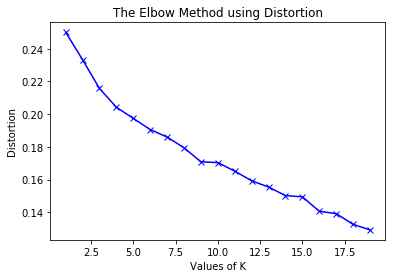

In [220]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

There is no clear elbow here therefore we look at the silhoutte score

In [221]:
sillhouette=[]
no_clusters=[]
for n_clusters in range(2,20):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(np.array(colombo_grouped.drop('Neighborhood', 1)))
    centers = clusterer.cluster_centers_

    score = silhouette_score(np.array(colombo_grouped.drop('Neighborhood', 1)), preds)
    sillhouette.append(score)
    no_clusters.append(n_clusters)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.6587624534260497)
For n_clusters = 3, silhouette score is 0.15494385329966393)
For n_clusters = 4, silhouette score is 0.16655043149320725)
For n_clusters = 5, silhouette score is 0.0900731231958947)
For n_clusters = 6, silhouette score is 0.09492436066087953)
For n_clusters = 7, silhouette score is 0.09768513746119391)
For n_clusters = 8, silhouette score is 0.08353005815913271)
For n_clusters = 9, silhouette score is 0.09212713347015009)
For n_clusters = 10, silhouette score is 0.10543779537193794)
For n_clusters = 11, silhouette score is 0.08289713487811015)
For n_clusters = 12, silhouette score is 0.06482486785260205)
For n_clusters = 13, silhouette score is 0.09716574663219048)
For n_clusters = 14, silhouette score is 0.037953893719167915)
For n_clusters = 15, silhouette score is 0.0945102968492965)
For n_clusters = 16, silhouette score is 0.07590759228729095)
For n_clusters = 17, silhouette score is 0.048931580956968396)
For n_clusters = 

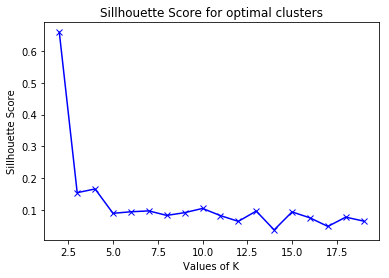

In [222]:
plt.plot(no_clusters, sillhouette, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Sillhouette Score') 
plt.title('Sillhouette Score for optimal clusters') 
plt.show() 

#### Run K- Means for the desired number of clusters

In [223]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(colombo_grouped.drop('Neighborhood', 1))

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 6, 4, 6, 6, 0, 0, 6, 6, 0])

Concatenate labels and geo data

In [224]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
colombo_merged = colombo_grouped[["Neighborhood"]].copy()
#Add cluster labels
colombo_merged["Cluster Labels"]=kmeans.labels_
#Assign geo data
colombo_merged=colombo_merged.merge(colombo_venues[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']],on='Neighborhood',how='left').drop_duplicates()

No of neighborhoods by cluster

In [225]:
colombo_merged['Cluster Labels'].value_counts()

6    23
0    20
4    11
2     3
7     1
5     1
3     1
1     1
Name: Cluster Labels, dtype: int64

### Cluster Visulalizations

In [226]:
X=colombo_grouped.copy()
X["Cluster"]=kmeans.labels_

In [227]:
#PCA with two principal components
pca_3d = PCA(n_components=3)

In [228]:
#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_3d = pd.DataFrame(pca_3d.fit_transform(X.drop(["Cluster","Neighborhood"], axis=1)))

In [229]:
#Variance of data explained by the three orthorgonal components
pca_3d.explained_variance_

array([0.01705968, 0.01181048, 0.00914723])

In [230]:
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

In [231]:
plotX = pd.concat([X,PCs_3d], axis=1, join='inner')

In [298]:
cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]
cluster3 = plotX[plotX["Cluster"] == 3]
cluster4 = plotX[plotX["Cluster"] == 4]
cluster5 = plotX[plotX["Cluster"] == 5]
cluster6 = plotX[plotX["Cluster"] == 6]
cluster7 = plotX[plotX["Cluster"] == 7]
#cluster8 = plotX[plotX["Cluster"] == 8]
#cluster9 = plotX[plotX["Cluster"] == 9]
#cluster10 = plotX[plotX["Cluster"] == 10]
#cluster11 = plotX[plotX["Cluster"] == 11]
#cluster12 = plotX[plotX["Cluster"] == 12]

In [236]:
init_notebook_mode(connected=True)

In [237]:
trace1 = go.Scatter3d(
                    x = cluster6["PC1_3d"],
                    y = cluster6["PC2_3d"],
                    z = cluster6["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 6",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster0["PC1_3d"],
                    y = cluster0["PC2_3d"],
                    z = cluster0["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster4["PC1_3d"],
                    y = cluster4["PC2_3d"],
                    z = cluster4["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 4",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2,trace3]

title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

### Visualizing on a map

In [248]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(colombo_merged['Neighborhood Latitude'], colombo_merged['Neighborhood Longitude'], colombo_merged['Neighborhood'], colombo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### Explore the fod scene within the clusters

In [210]:
food_var=['Neighborhood',
  'Asian Restaurant',
  'BBQ Joint',
  'Bakery',
 'Bar',
 'Bistro',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Burger Joint',
 'Cafeteria',
 'Café',
 'Chinese Restaurant',
 'Cocktail Bar',
 'Coffee Shop',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Cupcake Shop',
  'Dessert Shop',
 'Diner',
 'Donut Shop',
 'Eastern European Restaurant',
 'English Restaurant',
 'Fast Food Restaurant',
 'Fish & Chips Shop',
 'Fondue Restaurant',
 'Food',
 'Food & Drink Shop',
 'Food Court',
 'Food Truck',
 'French Restaurant',
 'Gastropub',
 'German Restaurant',
  'Halal Restaurant',
 'Hookah Bar',
 'Hot Dog Joint',
 'Hotel Bar',
 'Ice Cream Shop',
 'Indian Chinese Restaurant',
 'Indian Restaurant',
 'Irish Pub',
 'Italian Restaurant',
 'Japanese Restaurant',
  'Juice Bar',
 'Malay Restaurant',
 'Mediterranean Restaurant',
 'Middle Eastern Restaurant',
 'Noodle House',
 'North Indian Restaurant',
  'Pakistani Restaurant',
 'Pizza Place',
 'Pub',
 'Restaurant',
 'Sandwich Place',
 'Seafood Restaurant',
 'Snack Place',
 'South Indian Restaurant',
 'Sri Lankan Restaurant',
 'Steakhouse',
  'Sushi Restaurant',
 'Taco Place',
 'Tapas Restaurant',
 'Tea Room',
  'Thai Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Vietnamese Restaurant',
]

In [207]:
#Variables for food places possibly containing pizza
pizza_var=['Neighborhood',
  'Bar',
  'Bistro',
  'Café',
  'Coffee Shop',
  'Comfort Food Restaurant',
  'Diner',
  'Fast Food Restaurant',
  'Fish & Chips Shop',
  'Food Court',
  'Food Truck',
  'Hotel Bar',
  'Irish Pub',
  'Italian Restaurant',
  'Pizza Place',
  'Pub',
  'Restaurant',
  'Sandwich Place',
  'Seafood Restaurant',
  'Snack Place',
  'Tapas Restaurant',
  'Vegetarian / Vegan Restaurant',
]

### Observing presence of food spots vs places that potentially sell pizza

The reason for this is the ideal suburb will have many restaurants but fewer that would be competition

#### Cluster 0

In [251]:
cluster0['Food Total']=cluster0[food_var].sum(axis=1)
cluster0['Pizza Total']=cluster0[pizza_var].sum(axis=1)
cluster0['Food Pizza Ratio']=cluster0['Food Total']/cluster0['Pizza Total']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [259]:
pizza0=(cluster0[['Neighborhood','Food Total','Pizza Total','Food Pizza Ratio']].sort_values('Food Pizza Ratio',ascending=False)
                                                                         .replace(np.inf,np.nan)
                                                                         .dropna())
pizza0.head()

,Neighborhood,Food Total,Pizza Total,Food Pizza Ratio
42,Nugegoda,0.384615,0.076923,5.000000
28,Koswatte,0.333333,0.083333,4.000000
34,Maharagama,0.379310,0.103448,3.666667
39,Moratuwa,0.523810,0.142857,3.666667
29,Kotahena,0.350000,0.100000,3.500000


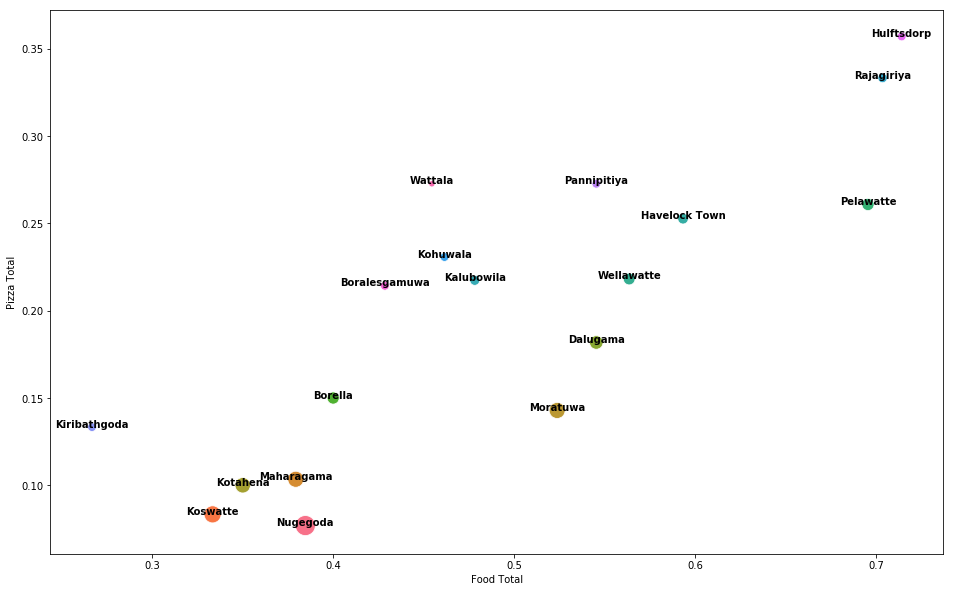

In [282]:
plt.figure(figsize=(16,10))
ax=sns.scatterplot(data=pizza0,x='Food Total',y='Pizza Total',hue='Neighborhood',size='Food Pizza Ratio',sizes=(40,400))
# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend().remove()

for line in range(0,pizza0.shape[0]):
     ax.text(pizza0['Food Total'].iloc[line], pizza0['Pizza Total'].iloc[line], pizza0.Neighborhood.iloc[line], horizontalalignment='center', size='medium', color='black', weight='semibold')

These seem to all be slightly outer suburbs to the heart of the city, or suburbs in the city but not the commerical hub; which have a large number of restaurants and eating but relatively less pizza spots, worth noting these suburbs see heavy movement of people and are ideal for restaurants.

By looking at a 2x2 of the above visual it becomes apparent in this cluster the most promising venue for a Pizzeria in this cluster is Moratuwa.

#### Cluster 6

In [299]:
cluster6['Food Total']=cluster6[food_var].sum(axis=1)
cluster6['Pizza Total']=cluster6[pizza_var].sum(axis=1)
cluster6['Food Pizza Ratio']=cluster6['Food Total']/cluster6['Pizza Total']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [300]:
pizza6=(cluster6[['Neighborhood','Food Total','Pizza Total','Food Pizza Ratio']].sort_values('Food Pizza Ratio',ascending=False)
                                                                         .replace(np.inf,np.nan)
                                                                         .dropna())
pizza6.head()

,Neighborhood,Food Total,Pizza Total,Food Pizza Ratio
11,Dematagoda,0.250000,0.062500,4.0000
18,"Kaduwela, Western Province",0.307692,0.076923,4.0000
1,Bambalapitiya,0.513889,0.222222,2.3125
26,Kollupitiya,0.631579,0.315789,2.0000
54,Sri Jayawardenepura Kotte,0.400000,0.200000,2.0000


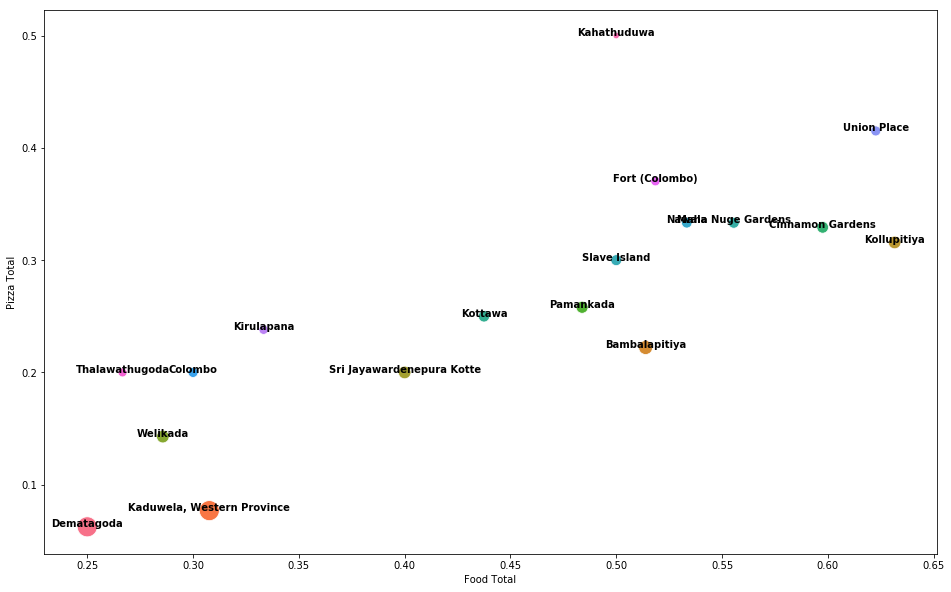

In [301]:
plt.figure(figsize=(16,10))
ax=sns.scatterplot(data=pizza6,x='Food Total',y='Pizza Total',hue='Neighborhood',size='Food Pizza Ratio',sizes=(40,400))
# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend().remove()

for line in range(0,pizza6.shape[0]):
     ax.text(pizza6['Food Total'].iloc[line], pizza6['Pizza Total'].iloc[line], pizza6.Neighborhood.iloc[line], horizontalalignment='center', size='medium', color='black', weight='semibold')

This cluster seems to have captured the heart of the city (With 2 exceptions). Looking at the quadrants here both presence of pizza and food on average is quite high especially for the central suburbs Colombo

It seems as though Sri Jayawardenapura Kotte, and Bambalapitiya show the most potential here, given that boh these locations are very central a slightly higher on average presence of potential pizza places is tolerable since the demand for food is also higher.

#### Cluster 4

In [302]:
cluster4['Food Total']=cluster4[food_var].sum(axis=1)
cluster4['Pizza Total']=cluster4[pizza_var].sum(axis=1)
cluster4['Food Pizza Ratio']=cluster4['Food Total']/cluster4['Pizza Total']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [303]:
pizza4=(cluster4[['Neighborhood','Food Total','Pizza Total','Food Pizza Ratio']].sort_values('Food Pizza Ratio',ascending=False)
                                                                         .replace(np.inf,np.nan)
                                                                         .dropna())
pizza4.head()

,Neighborhood,Food Total,Pizza Total,Food Pizza Ratio
2,Battaramulla,0.666667,0.066667,10.0
40,Narahenpita,0.400000,0.066667,6.0
21,Kandana,0.400000,0.100000,4.0
60,Wickramasinhapura,0.555556,0.222222,2.5
36,Maradana,0.476190,0.190476,2.5


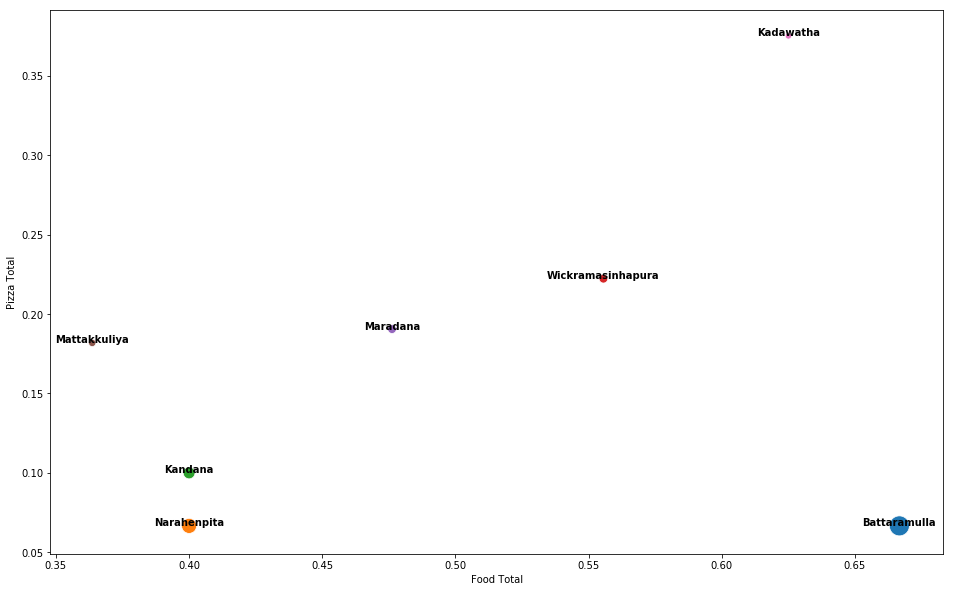

In [304]:
plt.figure(figsize=(16,10))
ax=sns.scatterplot(data=pizza4,x='Food Total',y='Pizza Total',hue='Neighborhood',size='Food Pizza Ratio',sizes=(40,400))
# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend().remove()

for line in range(0,pizza4.shape[0]):
     ax.text(pizza4['Food Total'].iloc[line], pizza4['Pizza Total'].iloc[line], pizza4.Neighborhood.iloc[line], horizontalalignment='center', size='medium', color='black', weight='semibold')

This cluster does seem random, but definitely share common location types at a similar spread according to Foursquare which is why they've been grouped together. Battaramulla, Kandana, Narehenpita and Kaduwela are all highly residential suburbs in Colombo, with Battaramulla having gone vast development in the past few years. It seems there is a large potential for a pizzeria seeing as there is a large presence of restaurants which we assume to be driven by a demand for dining, takeaway etc.

## Conclusion

Based on the clusters formed we were able to isolate suburbs and some common features to explain why they may have been clustered together, such as its position from city center, commercial resdiential nature etc.

Therefore it would not have been sufficient to look at a need for a pizzeria treating all suburbs equally since the clusters of suburbs are very different to each other and therefore would naturally follow non-identical spending behaviours.

Based on the above segmentation within clusters in a highly residential area with a seemingly large demand for restaurants, it seems the presence of restaurants selling pizzas is much less than the apparent food demand in <b>Battaramulla </b>. 

In the slightly further suburbs of Colombo it seems there is an opportunity to enter the market in <b> Moratuwa </b>.